# A closer look at COVID-19 data
In this notebook I want to take a closer look at covid-19 patients data from Korea. Since I am especially interested in the impact of the Virus, I am using a dataset that includes patient data. This notebook follows the CRISP-DM process and the steps 1 (developing business understanding) and step 2 (developing data understanding) are excecuted in parallel.

Sources:
The data is originally from the [Korea Centers for Disease Control & Prevention](http://www.cdc.go.kr/).
The data used in this repository is from a [kaggle user group](https://www.kaggle.com/kimjihoo/coronavirusdataset) called dataartist that aggregated the Korean government data from different regions.

# Business and data understanding
## Business questions:
For the business questions I focus on topics that are relevant to fight the pandemic efficiently.
1. How are the infections distributed amongst age and sex?
2. How long are the hospital stays per age and sex?
3. After how many days do the patients who do not recover die?



In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling
import numpy as np
import seaborn as sns
import datetime as dt
%matplotlib inline

In [2]:
case_df = pd.read_csv("data/Case.csv")
patient_df = pd.read_csv("data/PatientInfo.csv")

In [3]:
case_df.head()

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Yongsan-gu,True,Itaewon Clubs,139,37.538621,126.992652
1,1000002,Seoul,Gwanak-gu,True,Richway,119,37.48208,126.901384
2,1000003,Seoul,Guro-gu,True,Guro-gu Call Center,95,37.508163,126.884387
3,1000004,Seoul,Yangcheon-gu,True,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,1000005,Seoul,Dobong-gu,True,Day Care Center,43,37.679422,127.044374


In [4]:
case_df.infection_case.value_counts()

overseas inflow                    17
etc                                17
contact with patient               16
Shincheonji Church                 15
Itaewon Clubs                       9
                                   ..
Jung-gu Fashion Company             1
Yeongdeungpo Learning Institute     1
Bonghwa Pureun Nursing Home         1
Wings Tower                         1
Gumi Elim Church                    1
Name: infection_case, Length: 81, dtype: int64

In [5]:
case_df.shape

(174, 8)

#### Comment
While the table case_df holds interesting information it is a bit short with 174 rows and therefore not suitable for statistical significant findings. Let's see if the table patient_df is better suited.

In [6]:
patient_df.head(2)

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released


In [7]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          5165 non-null   int64 
 1   sex                 4043 non-null   object
 2   age                 3785 non-null   object
 3   country             5165 non-null   object
 4   province            5165 non-null   object
 5   city                5071 non-null   object
 6   infection_case      4246 non-null   object
 7   infected_by         1346 non-null   object
 8   contact_number      791 non-null    object
 9   symptom_onset_date  690 non-null    object
 10  confirmed_date      5162 non-null   object
 11  released_date       1587 non-null   object
 12  deceased_date       66 non-null     object
 13  state               5165 non-null   object
dtypes: int64(1), object(13)
memory usage: 565.0+ KB


In [8]:
patient_df.shape

(5165, 14)

In [9]:
patient_df.infection_case.value_counts()

contact with patient                             1610
overseas inflow                                   840
etc                                               703
Itaewon Clubs                                     162
Richway                                           128
Guro-gu Call Center                               112
Shincheonji Church                                107
Coupang Logistics Center                           80
Yangcheon Table Tennis Club                        44
Day Care Center                                    43
SMR Newly Planted Churches Group                   36
Onchun Church                                      33
Bonghwa Pureun Nursing Home                        31
gym facility in Cheonan                            30
Ministry of Oceans and Fisheries                   28
Wangsung Church                                    24
Cheongdo Daenam Hospital                           21
Dongan Church                                      17
Eunpyeong St. Mary's Hospita

In [10]:
patient_df.profile_report()

### Data understanding:
The gathered data seems to be suitable for the stated business question. I will proceed to prepare the data.

# Prepare Data
I will prepare the data for each stated business question so they are ready to be modeled in the next step.

## Function defenitions
Below necessary functions are defined

In [11]:
def calculate_days_in_hsptl(df, startdate, enddate):
    '''
    Function removes all rows that are missing values in the startdate or enddate column and 
    then calculates the number of days spend in the hospital.
    The results are saved in a new column "days_in_hsptl" and are converted to int
    ARGS:
    df - (pandas dataframe) with the columns of start and enddate of the hospital stay
    startdate - (string) colum nname in the dataframe that has the starting date of the hospital stay
    enddate - (string) column name in the dataframe that has the ending date of the hospital stay
    
    RETURNS:
    df - (pandas dataframe) with the new column of "days_in_hsptl" 
    '''
    # drop rows that are missing values to calculate length of stay
    df.dropna(subset = [enddate, startdate], inplace = True)
    df["days_in_hsptl"] = (df[enddate] - df[startdate]).astype(str)

    # change number of days to int
    df["days_in_hsptl"] = df.days_in_hsptl.apply(lambda x: x[:-5]).astype(int)
    
    return df

### General preparations
Preparations needed for all following analysis
#### Todo:
- [x] Convert date columns from str to datetime format
- [x] Patient id should be a str instead of int

In [12]:
general_df = patient_df.copy()

In [13]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          5165 non-null   int64 
 1   sex                 4043 non-null   object
 2   age                 3785 non-null   object
 3   country             5165 non-null   object
 4   province            5165 non-null   object
 5   city                5071 non-null   object
 6   infection_case      4246 non-null   object
 7   infected_by         1346 non-null   object
 8   contact_number      791 non-null    object
 9   symptom_onset_date  690 non-null    object
 10  confirmed_date      5162 non-null   object
 11  released_date       1587 non-null   object
 12  deceased_date       66 non-null     object
 13  state               5165 non-null   object
dtypes: int64(1), object(13)
memory usage: 565.0+ KB


In [14]:
# saving all date columns in a list and then changing them to datetime format
date_cols = ["symptom_onset_date", "confirmed_date", "released_date", "deceased_date"]
for date_col in date_cols:
    general_df[date_col] = pd.to_datetime(general_df[date_col], errors = "coerce")

In [15]:
# Changing patient_id to string format
general_df["patient_id"] = general_df["patient_id"].astype(str)

In [16]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          5165 non-null   object        
 1   sex                 4043 non-null   object        
 2   age                 3785 non-null   object        
 3   country             5165 non-null   object        
 4   province            5165 non-null   object        
 5   city                5071 non-null   object        
 6   infection_case      4246 non-null   object        
 7   infected_by         1346 non-null   object        
 8   contact_number      791 non-null    object        
 9   symptom_onset_date  689 non-null    datetime64[ns]
 10  confirmed_date      5162 non-null   datetime64[ns]
 11  released_date       1587 non-null   datetime64[ns]
 12  deceased_date       66 non-null     datetime64[ns]
 13  state               5165 non-null   object      

### Preparing for: Q1 "How are the infections distributed amongst age and sex?"
For this question I will need the patient data like age and sex. 
Therefore "age" should be a numerical variable and "sex" a categorical variable.
#### Todo:
- [x] Remove rows that have missing entries in "age", "sex" or "confirmed date"
- [x] Remove the "s" in the age entries, save it as an int and change column name to reflect the change

In [17]:
# Copy dataframe so no changes are made to the original
q1_df = general_df.copy()

In [18]:
# drop all rows that are empty in age or sex
q1_df.dropna(subset = ["age", "sex", "confirmed_date"],inplace = True)

In [19]:
# sanity check if all nan values are dropped
q1_df.sex.value_counts()

female    2065
male      1714
Name: sex, dtype: int64

In [20]:
# removes the "s" of the age range
q1_df["age"] = q1_df["age"].str.replace("s", "").astype(int)

# rename the column to reflect that it stands for the bracket and not only the specific age
q1_df.rename(columns = {"age": "age_bracket"}, inplace = True)

# sanity check if age is now an int
type(q1_df.age_bracket[0])

numpy.int64

In [21]:
# sanity check if all nan values are dropped
q1_df.age_bracket.value_counts()

20     897
50     667
30     523
40     516
60     482
70     232
10     177
80     170
0       65
90      49
100      1
Name: age_bracket, dtype: int64

### Preparing for  Q2 "How long are the hospital stays per age and sex for the patients that recover?"

#### Todo:
- [x] Drop rows without confirmed date, age or sex
- [x] Remove "s" from age and rename column
- [x] Calculate length of hospital stay for each case
    - [x] Save as int

In [22]:
q2_df = general_df.copy()

In [23]:
q2_df.dropna(subset = ["confirmed_date", "age", "sex"], inplace = True)

In [24]:
# removes the "s" of the age range
q2_df["age"] = q2_df["age"].str.replace("s", "").astype(int)

# rename the column to reflect that it stands for the bracket and not only the specific age
q2_df.rename(columns = {"age": "age_bracket"}, inplace = True)

In [25]:
# calculate the number of days in the hospital per case
q2_1_df = q2_df.query("state == 'released'").copy()

q2_1_df = calculate_days_in_hsptl(q2_1_df, "confirmed_date", "released_date")

### Preparing for Q3 "After how many days do the patients who do not recover die?"
Todo:
- [x] Remove rows that do not have a deceased date
- [x] Check if enough data is available
- [x] Calculate the length of the hospital stays


In [26]:
q2_2_df = q2_df.query("deceased_date != 'NaT'").copy()

In [27]:
q2_2_df.state.value_counts()

deceased    66
Name: state, dtype: int64

In [28]:
q2_2_df.iloc[0,12]

Timestamp('2020-02-23 00:00:00')

In [29]:
len(q2_2_df)

66

In [30]:
# Calculate days in hospital
q2_2_df = calculate_days_in_hsptl(q2_2_df, "confirmed_date", "deceased_date")

# Model Data
## General inspection of data
To begin the model phase I will craft some general charts. This will help to get an impression of the dataset.



In [31]:
colors = ["cornflowerblue", "lightcoral"]

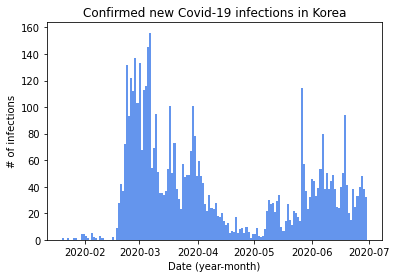

In [32]:
# Histogram of the confirmed cases per day 
plt.hist(general_df.confirmed_date, bins = general_df.confirmed_date.nunique(), color = colors[0])
plt.title("Confirmed new Covid-19 infections in Korea")
plt.ylabel("# of infections")
plt.xlabel("Date (year-month)")
plt.savefig("figures/Confiremd_Covid_infections_Korea.png", transparent = True, dpi=150);

#### Comment
This histogram nicely shows the first and second wave of Covid-19 infections in Korea

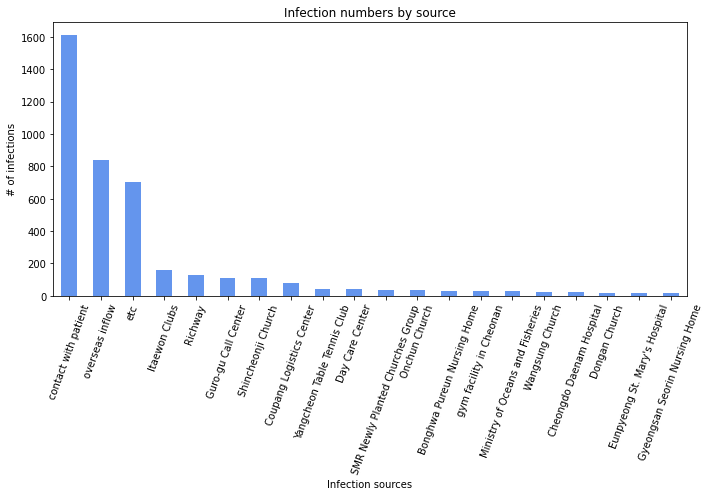

In [33]:
general_df.infection_case.value_counts().iloc[:20].plot(kind = "bar", figsize = (10,7), color = colors[0])
plt.xticks(rotation = 70)
plt.title("Infection numbers by source")
plt.ylabel("# of infections")
plt.xlabel("Infection sources")
plt.tight_layout()
plt.savefig("figures/Source_of_infections.png", transparent = True, dpi=150);


## Q1 How are the infections distributed amongst age and sex?

In [34]:
q1_df["sex"].value_counts().values

array([2065, 1714])

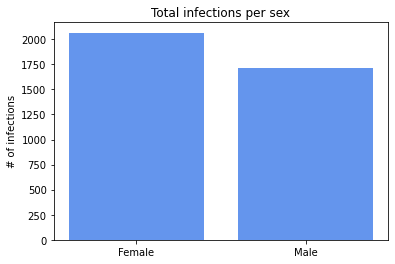

In [35]:
# Barplot of total infections per sex
plt.bar(["Female", "Male"], q1_df["sex"].value_counts().values, color = colors[0])
plt.title("Total infections per sex")
plt.ylabel("# of infections")
plt.savefig("figures/infections_by_sex.png", transparent = True, dpi=150);

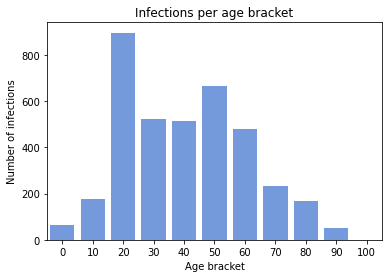

In [36]:
# Barplot of total infections per age bracket
sns.countplot(x = "age_bracket", data = q1_df, color = colors[0])
plt.title("Infections per age bracket")
plt.ylabel("Number of infections")
plt.xlabel("Age bracket")
plt.savefig("figures/infections_by_age.png", transparent = True, dpi=150);

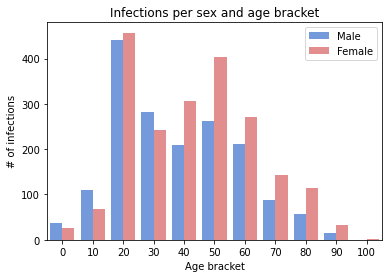

In [37]:
# Barplot of total infections per age bracket and sex
sns.countplot(x = "age_bracket",hue= "sex", data = q1_df, palette = colors)
plt.xlabel("Age bracket")
plt.ylabel("# of infections")
plt.title("Infections per sex and age bracket")
plt.legend(["Male", "Female"])
plt.savefig("figures/infections.png", transparent = True, dpi=150);

# Q 2 How long are the hospital stays per age and sex for patients that recover?

In [38]:
q2_1_df.days_in_hsptl.mean()

24.802933673469386

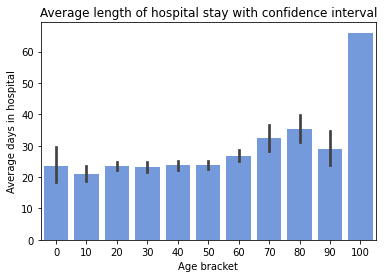

In [39]:
sns.barplot(x = "age_bracket", y = "days_in_hsptl", data = q2_1_df, color = colors[0])
plt.title("Average length of hospital stay with confidence interval")
plt.xlabel("Age bracket")
plt.ylabel("Average days in hospital")
plt.savefig("figures/avg_length_hsptl_stay.png", transparent = True, dpi=150);

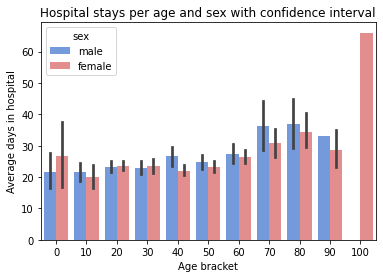

In [40]:
sns.barplot(x = "age_bracket", y = "days_in_hsptl", data = q2_1_df, hue = "sex", palette = colors)
plt.title("Hospital stays per age and sex with confidence interval")
plt.xlabel("Age bracket")
plt.ylabel("Average days in hospital")
plt.savefig("figures/avg_lngth_hsptl_stay_by_sex.png", transparent = True, dpi=150);

### Result of Q2 
The first graph of this section shows that the duration of the hospital stay of people who recover are fairly constant at 23 days until the age of 60. From 60 upwards the days needed to recover rise constantly to a maximum of 33. For patients in the age bracket of 90 the length of stay dips again but this could be due to low amount of data as the confidence intervals suggests. There is only one patient over a 100 who recovered after over 60 days.

Another interesting observation is that below 39 male patients recovery a little bit faster (although not enough to be a statistical significant difference) And after 40 the females recover faster.

## Q 3 After how many days do the different groups die?

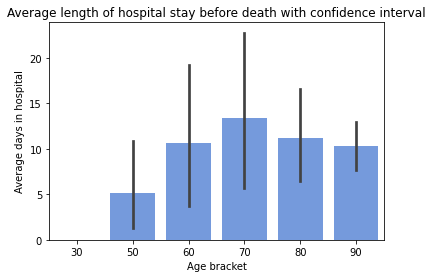

In [41]:
sns.barplot(x = "age_bracket", y = "days_in_hsptl", data = q2_2_df, color = colors[0])
plt.title("Average length of hospital stay before death with confidence interval")
plt.xlabel("Age bracket")
plt.ylabel("Average days in hospital")
plt.savefig("figures/hsptl_stay_dcsd_patients.png", transparent = True, dpi=150);

### Result of Q 3
The big confidence intervals show that we do not have a very good databasis to answer this question. However it is possible to see that there are no deaths below 50 years of age and that the average hospital stay increases until the 70s and then decreases again with very old age of 80s and 90s. The average stay is also shorter than for people who get healthy again, but this is an expected result. 

<AxesSubplot:>

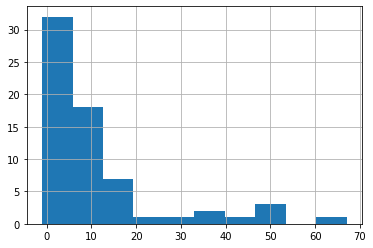

In [42]:
q2_2_df["days_in_hsptl"].hist(bins = 10, )

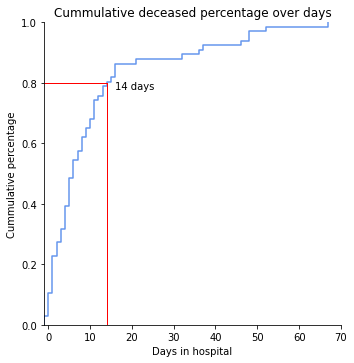

In [43]:
sns.displot(q2_2_df, x="days_in_hsptl", kind="ecdf", color = colors[0])
# draw vertical line from 80% 
plt.plot([14, 14], [0, 0.8], 'k-', lw=1, color = "red")
plt.plot([-1, 14], [0.8, 0.8], 'k-', lw=1, color = "red")
plt.xlim(-1, 70)
plt.annotate("14 days", (16, 0.78))
plt.title("Cummulative deceased percentage over days")
plt.xlabel("Days in hospital")
plt.ylabel("Cummulative percentage")
plt.savefig("figures/Dcsd_patients_cum.png", transparent = True, dpi=150);

### Result
The plot shows that within two weeks 80 percent of the patients die given they will not recover. It forms a critical milestone in comparison with an average length in hospital stay of patients who do recover of almost 25 days.